In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

## Load data and transformers back

In [3]:
import pickle
with open('../count-power-transformer.pkl', 'rb') as inf:
    pt = pickle.load(inf)
data = pd.read_pickle('../data-count-transformed.pkl.xz')
print(pt, pt.lambdas_)
data.head()

PowerTransformer(copy=True, method='box-cox', standardize=False) [0.31567024]


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_transformed
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,4.433145
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,6.982674
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,6.292274
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3.950910
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,0.000000


## Add dummy variables

In [4]:
season = pd.get_dummies(data['season'],prefix='season')
weather = pd.get_dummies(data['weather'],prefix='weather')

data_fe = pd.concat([data, season, weather],axis=1)
data_fe.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,count_transformed,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,16,4.433145,1,0,0,0,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,40,6.982674,1,0,0,0,1,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,32,6.292274,1,0,0,0,1,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,13,3.950910,1,0,0,0,1,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,1,0.000000,1,0,0,0,1,0,0,0


## Add year, month, date and hour columns

In [5]:
date_time_splitting = data_fe.datetime.map(
    lambda t: [t.year, t.month, t.day, t.hour]
)

In [6]:
date_time_splitting

0           [2011, 1, 1, 0]
1           [2011, 1, 1, 1]
2           [2011, 1, 1, 2]
3           [2011, 1, 1, 3]
4           [2011, 1, 1, 4]
                ...        
10881    [2012, 12, 19, 19]
10882    [2012, 12, 19, 20]
10883    [2012, 12, 19, 21]
10884    [2012, 12, 19, 22]
10885    [2012, 12, 19, 23]
Name: datetime, Length: 10886, dtype: object

In [7]:
date_time = date_time_splitting.apply(pd.Series)
date_time.columns = ['year', 'month', 'day', 'hour']
date_time

,year,month,day,hour
0,2011,1,1,0
1,2011,1,1,1
2,2011,1,1,2
3,2011,1,1,3
4,2011,1,1,4
...,...,...,...,...
10881,2012,12,19,19
10882,2012,12,19,20
10883,2012,12,19,21
10884,2012,12,19,22


In [8]:
data_fe = pd.concat([data_fe, date_time],axis=1)
data_fe.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,season_3,season_4,weather_1,weather_2,weather_3,weather_4,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,0,0,1,0,0,0,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,0,0,1,0,0,0,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,0,0,1,0,0,0,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,0,0,1,0,0,0,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,0,0,1,0,0,0,2011,1,1,4


## Specify features used for training

In [9]:
features = [
    'season_1', 'season_2', 'season_3', 'season_4',
    'weather_1', 'weather_2', 'weather_3', 'weather_4',
    'year', 'month', 'day', 'hour',
    'holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
]
target = 'count_transformed'

In [10]:
x = data_fe[features]
y = data_fe[target]
count_original = data_fe['count']

## Split sample data into training set and testing set

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train, x_testing, y_train, _, _, y_testing = train_test_split(
    x, y, count_original,
    test_size=0.25, random_state=42,
)
print(
    'training set:', x_train.shape, y_train.shape,
    '\n',
    'testing set:', x_testing.shape, y_testing.shape,
)

training set: (8164, 18) (8164,) 
 testing set: (2722, 18) (2722,)


## Train models then evaluate the performance

In [13]:
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error

In [14]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor']

In [15]:
for model in models:
    model.fit(x_train, y_train)

f:\venvs\cisco-kaggle\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
f:\venvs\cisco-kaggle\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [16]:
rmsle = []
predictions = []

for name, model in zip(model_names, models):
    y_pred = model.predict(x_testing)
    y_pred = pt.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    predictions.append(y_pred)
    rmsle.append(
        np.sqrt(
            mean_squared_log_error(
                y_pred,
                y_testing,
            )
        )
    )

result = pd.DataFrame({
    'Model': model_names,
    'RMSLE': rmsle,
    'Note': 'dummies and date'
})
result

,Model,RMSLE,Note
0,RandomForestRegressor,0.339802,dummies and date
1,AdaBoostRegressor,0.628957,dummies and date
2,BaggingRegressor,0.340389,dummies and date
3,SVR,1.128754,dummies and date
4,KNeighborsRegressor,0.871793,dummies and date


In [17]:
first_training = pd.read_pickle('../first_training_rmsle.pkl')

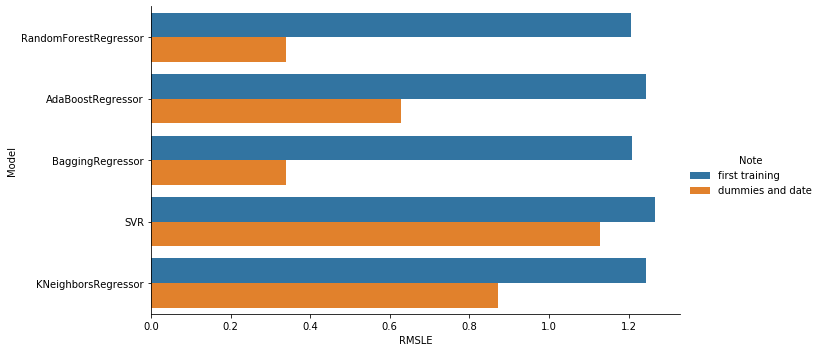

In [18]:
sns.catplot(
    x='RMSLE', y='Model', hue='Note',
    data=pd.concat([first_training, result], axis=0),
    kind='bar', height=5, aspect=2
)

In [19]:
result.to_pickle('../rmsle_dummies_and_date.pkl')

In [20]:
data_fe.to_pickle('../data-dummies-and-date.pkl.xz')